# Capstone 3 - Pre-Processing and Training

### Table of contents
* [1.0 Intorduction](#1.0)
    * [1.1 Purpose](#1.1)
    * [1.2 Approach](#1.2)
* [2.0 Load the data](#2.0)
    * [2.1 Imports](#2.1)
    * [2.2 Load data](#2.2)
* [3.0 Stationarity and differencing](#3.0)
    * [3.1 Base Autocorrelation](#3.1)
    * [3.2 Augmented Dickey-Fuller](#3.2)
    * [3.3 KPSS stationarity test](#3.3)
    * [3.4 Stationarity function](#3.4)
    * [3.5 Seasonal stationarity testing](#3.5)
    * [3.6 Seasonally decomposition](#3.6)
    * [3.7 ACF and PACF on stationary data](#3.7)
* [4.0 Baseline ARIMA](#4.0)
    * [4.1 Train/Test split](#3.1)
        * [4.1.1 Metrics of evaluation](#3.2)
    * [4.2 ARIMA with basic p,d,q](#3.3)
        * [4.2.1 Plotting the basic ARIMA residuals](#3.4)
        * [4.2.2 Plotting the basic ARIMA predictions](#3.5)
        * [4.2.3 Evaluating basic ARIMA](#3.6)
    * [4.3 ARIMA with pre-figured p,d,q](#3.7)
        * [4.3.1 Plotting the seasonal ARIMA residuals](#3.7)
        * [4.3.2 Plotting the seasonal ARIMA predictions](#3.7)
        * [4.3.3 Evaluating seasonal ARIMA](#3.7)
    * [4.4 Problem with the first models](#3.7)
    * [4.5 Multi-seasonal time series analysis](#3.7)
        * [4.5.1 Seasonal breakdown](#3.7)
    * [4.6 TBATS](#3.7)
        * [4.6.1 Fitting the model](#3.7)
        * [4.6.2 Plotting the multi-seasonal TBATS predictions](#3.7)
        * [4.6.3 Evaluating multi-seasonal TBATS](#3.7)
    * [4.7 Comparing model results](#4.7)
* [5.0 Analysis inclusive of exogenous variables](#5.0)
    * [5.1 Seasonality as exogenous variables using Fourier transformation](#5.1)
    * [5.2 Adding promotional item information](#5.2)
    * [5.3 Building our new ARIMAs with exogenous variables](#5.3)
        * [5.3.1 ARIMAs with both exogenous variables](#5.3.1)
        * [5.3.2 Plotting the ARIMA with both exogenous variables](#5.3.2)
        * [5.3.3 Evaluating ARIMA with both exogenous variables](#5.3.3)
    * [5.4 ARIMA with only Fourier values as exogenous variables](#5.4)
        * [5.4.1 Fourier-only ARIMA](#5.4.1)
        * [5.4.2 Plotting the ARIMA with Fourier values as exogenous variables](#5.4.2)
        * [5.4.3 Evaluating ARIMA with Fourier values as exogenous variables](#5.4.3)
    * [5.5 Promotional values-only ARIMA](#5.5)
        * [5.5.1 ARIMA with only promotional values as exogenous variables](#5.5.1)
        * [5.5.2 Plotting the ARIMA with only promotional values as variables](#5.5.2)
        * [5.5.3 Evaluating ARIMA with only promotional values as variables](#5.5.3)
    * [5.6 Combining ARIMA with TBATS](#5.6)
        * [5.6.1 Plotting the best ARIMA and TBATS combination model](#5.6.1)
        * [5.6.2 Evaluating ARIMA and TBATS combination model](#5.6.2)
* [6.0 Final model evaluation](#6.0)
    * [6.1 Model comparison: MAPE](#6.1)
    * [6.2 Model timing](#6.2)
    * [6.3 Model comparison: R^2](#6.3)
* [7.0 Summary](#7.0)
    

### 1.0 Introduction: <a id='1.0'></a>

In order to stay in business, commercial grocery stores must offer prices that are commensurate with competitors, offer deals to entice customers, and accurately predict which products, and the quantity of those products, to keep in stock. These considerations are confounded by the effect of both seasonal and regional trends.

Especially for grocers, the consequences of poor inventory management are dire. Perishable items like fruits and vegetables can rot before selling if they are overstocked. Conversely, many locations do not have the real estate or capability to store overstocked, low-demand items that are not selling. According to Retail Wire, overstocking costs the average retailer 3.2% in lost revenue, while understocking items can cost 4.1%. A review of the data has shown that overstocks are costing retailers \\$123.4 billion every year, and understocks remove another \\$129.5 billion from net inflows. [1]

#### 1.1 Purpose<a id='1.1'></a>

Using Kaggle data available from Favorita grocery stores located in Ecuador [2], we will assess and predict sales of available items using time series analysis. There are multiple datasets that will require some data to be merged. We have information on transactions, stores, regions, holidays, and even oil pricing.

[1] https://www.retailwire.com/discussion/retailers-suffer-the-high-cost-of-overstocks-and-out-of-stocks/

[2] Alexis Cook, DanB, inversion, Ryan Holbrook. (2021). Store Sales - Time Series Forecasting. Kaggle. https://kaggle.com/competitions/store-sales-time-series-forecasting


#### 1.2 Approach<a id='1.2'></a>

We will use machine learning time series analysis to forecast sales of different types of items across dozens of stores. This will allow Favorita to become more efficient with its distribution of resources, and more likely to attract customers to purchase certain products at certain times. This analysis can also inform the company of the best times to offer discounts, whether to stock up on certain items, and knowledge of general market trends.


### 2.0 Load our cleaned data<a id='2.0'></a>

#### 2.1 Imports<a id='2.1'></a>

In [2]:
# import needed modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.dates import DateFormatter
import seaborn as sns
import os
import scipy
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.colors import BoundaryNorm, ListedColormap
from datetime import timedelta, datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.tbats import TBATS
from pmdarima.arima import ARIMA as pmdARIMA
from pmdarima.arima import auto_arima as autoARIMA

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
"""
Author: Kishan Manani
License: BSD-3 Clause
An implementation of MSTL [1], an algorithm for time series decomposition when
there are multiple seasonal components.
This implementation has the following differences with the original algorithm:
- Missing data must be handled outside of this class.
- The algorithm proposed in the paper handles a case when there is no
seasonality. This implementation assumes that there is at least one seasonal
component.
[1] K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple
Seasonal Patterns
https://arxiv.org/pdf/2107.13462.pdf
"""
from typing import Dict, Optional, Sequence, Tuple, Union
import warnings

import numpy as np
import pandas as pd
from scipy.stats import boxcox

#from statsmodels.tools.typing import ArrayLike1D
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.tsatools import freq_to_period


class MSTL:
    """
    MSTL(endog, periods=None, windows=None, lmbda=None, iterate=2,
         stl_kwargs=None)
    Season-Trend decomposition using LOESS for multiple seasonalities.
    Parameters
    ----------
    endog : array_like
        Data to be decomposed. Must be squeezable to 1-d.
    periods : {int, array_like, None}, optional
        Periodicity of the seasonal components. If None and endog is a pandas
        Series or DataFrame, attempts to determine from endog. If endog is a
        ndarray, periods must be provided.
    windows : {int, array_like, None}, optional
        Length of the seasonal smoothers for each corresponding period.
        Must be an odd integer, and should normally be >= 7 (default). If None
        then default values determined using 7 + 4 * np.arange(1, n + 1, 1)
        where n is number of seasonal components.
    lmbda : {float, str, None}, optional
        The lambda parameter for the Box-Cox transform to be applied to `endog`
        prior to decomposition. If None, no transform is applied. If "auto", a
        value will be estimated that maximizes the log-likelihood function.
    iterate : int, optional
        Number of iterations to use to refine the seasonal component.
    stl_kwargs: dict, optional
        Arguments to pass to STL.
    See Also
    --------
    statsmodels.tsa.seasonal.STL
    References
    ----------
    .. [1] K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
        MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with
        Multiple Seasonal Patterns. arXiv preprint arXiv:2107.13462.
    Examples
    --------
    Start by creating a toy dataset with hourly frequency and multiple seasonal
    components.
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> import pandas as pd
    >>> pd.plotting.register_matplotlib_converters()
    >>> np.random.seed(0)
    >>> t = np.arange(1, 1000)
    >>> trend = 0.0001 * t ** 2 + 100
    >>> daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
    >>> weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
    >>> noise = np.random.randn(len(t))
    >>> y = trend + daily_seasonality + weekly_seasonality + noise
    >>> index = pd.date_range(start='2000-01-01', periods=len(t), freq='H')
    >>> data = pd.DataFrame(data=y, index=index)
    Use MSTL to decompose the time series into two seasonal components
    with periods 24 (daily seasonality) and 24*7 (weekly seasonality).
    >>> from statsmodels.tsa.seasonal import MSTL
    >>> res = MSTL(data, periods=(24, 24*7)).fit()
    >>> res.plot()
    >>> plt.tight_layout()
    >>> plt.show()
    .. plot:: plots/mstl_plot.py
    """

    def __init__(
        self,
        endog,
        *,
        periods: Optional[Union[int, Sequence[int]]] = None,
        windows: Optional[Union[int, Sequence[int]]] = None,
        lmbda: Optional[Union[float, str]] = None,
        iterate: int = 2,
        stl_kwargs: Optional[Dict[str, Union[int, bool, None]]] = None,
    ):
        self.endog = endog
        self._y = self._to_1d_array(endog)
        self.nobs = self._y.shape[0]
        self.lmbda = lmbda
        self.periods, self.windows = self._process_periods_and_windows(
            periods, windows
        )
        self.iterate = iterate
        self._stl_kwargs = self._remove_overloaded_stl_kwargs(
            stl_kwargs if stl_kwargs else {}
        )

    def fit(self):
        """
        Estimate a trend component, multiple seasonal components, and a
        residual component.
        Returns
        -------
        DecomposeResult
            Estimation results.
        """
        num_seasons = len(self.periods)
        iterate = 1 if num_seasons == 1 else self.iterate

        # Box Cox
        if self.lmbda == "auto":
            y, lmbda = boxcox(self._y, lmbda=None)
            self.est_lmbda = lmbda
        elif self.lmbda:
            y = boxcox(self._y, lmbda=self.lmbda)
        else:
            y = self._y

        # Get STL fit params
        stl_inner_iter = self._stl_kwargs.pop("inner_iter", None)
        stl_outer_iter = self._stl_kwargs.pop("outer_iter", None)

        # Iterate over each seasonal component to extract seasonalities
        seasonal = np.zeros(shape=(num_seasons, self.nobs))
        deseas = y
        for _ in range(iterate):
            for i in range(num_seasons):
                deseas = deseas + seasonal[i]
                res = STL(
                    endog=deseas,
                    period=self.periods[i],
                    seasonal=self.windows[i],
                    **self._stl_kwargs,
                ).fit(inner_iter=stl_inner_iter, outer_iter=stl_outer_iter)
                seasonal[i] = res.seasonal
                deseas = deseas - seasonal[i]

        seasonal = np.squeeze(seasonal.T)
        trend = res.trend
        rw = res.weights
        resid = deseas - trend

        # Return pandas if endog is pandas
        if isinstance(self.endog, (pd.Series, pd.DataFrame)):
            index = self.endog.index
            y = pd.Series(y, index=index, name="observed")
            trend = pd.Series(trend, index=index, name="trend")
            resid = pd.Series(resid, index=index, name="resid")
            rw = pd.Series(rw, index=index, name="robust_weight")
            cols = [f"seasonal_{period}" for period in self.periods]
            if seasonal.ndim == 1:
                seasonal = pd.Series(seasonal, index=index, name="seasonal")
            else:
                seasonal = pd.DataFrame(seasonal, index=index, columns=cols)

        # Avoid circular imports
        from statsmodels.tsa.seasonal import DecomposeResult

        return DecomposeResult(y, seasonal, trend, resid, rw)

    def __str__(self):
        return (
            "MSTL(endog,"
            f" periods={self.periods},"
            f" windows={self.windows},"
            f" lmbda={self.lmbda},"
            f" iterate={self.iterate})"
        )

    def _process_periods_and_windows(
        self,
        periods: Union[int, Sequence[int], None],
        windows: Union[int, Sequence[int], None],
    ) -> Tuple[Sequence[int], Sequence[int]]:
        periods = self._process_periods(periods)

        if windows:
            windows = self._process_windows(windows, num_seasons=len(periods))
            periods, windows = self._sort_periods_and_windows(periods, windows)
        else:
            windows = self._process_windows(windows, num_seasons=len(periods))
            periods = sorted(periods)

        if len(periods) != len(windows):
            raise ValueError("Periods and windows must have same length")

        # Remove long periods from decomposition
        if any(period >= self.nobs / 2 for period in periods):
            warnings.warn(
                "A period(s) is larger than half the length of time series."
                " Removing these period(s)."
            )
            periods = tuple(
                period for period in periods if period < self.nobs / 2
            )
            windows = windows[: len(periods)]

        return periods, windows

    def _process_periods(
        self, periods: Union[int, Sequence[int], None]
    ) -> Sequence[int]:
        if periods is None:
            periods = (self._infer_period(),)
        elif isinstance(periods, int):
            periods = (periods,)
        else:
            pass
        return periods

    def _process_windows(
        self,
        windows: Union[int, Sequence[int], None],
        num_seasons: int,
    ) -> Sequence[int]:
        if windows is None:
            windows = self._default_seasonal_windows(num_seasons)
        elif isinstance(windows, int):
            windows = (windows,)
        else:
            pass
        return windows

    def _infer_period(self) -> int:
        freq = None
        if isinstance(self.endog, (pd.Series, pd.DataFrame)):
            freq = getattr(self.endog.index, "inferred_freq", None)
        if freq is None:
            raise ValueError("Unable to determine period from endog")
        period = freq_to_period(freq)
        return period

    @staticmethod
    def _sort_periods_and_windows(
        periods, windows
    ) -> Tuple[Sequence[int], Sequence[int]]:
        if len(periods) != len(windows):
            raise ValueError("Periods and windows must have same length")
        periods, windows = zip(*sorted(zip(periods, windows)))
        return periods, windows

    @staticmethod
    def _remove_overloaded_stl_kwargs(stl_kwargs: Dict) -> Dict:
        args = ["endog", "period", "seasonal"]
        for arg in args:
            stl_kwargs.pop(arg, None)
        return stl_kwargs

    @staticmethod
    def _default_seasonal_windows(n: int) -> Sequence[int]:
        return tuple(7 + 4 * i for i in range(1, n + 1))  # See [1]

    @staticmethod
    def _to_1d_array(x):
        y = np.ascontiguousarray(np.squeeze(np.asarray(x)), dtype=np.double)
        if y.ndim != 1:
            raise ValueError("y must be a 1d array")
        return y

#### 2.2 Load data<a id='2.2'></a>

In [5]:
df = pd.read_csv('./favorita_data.csv')

In [6]:
df

,Unnamed: 0,store_nbr,family,sales,onpromotion,city,state,type,cluster,local_holiday,regional_holiday,national_holiday,transactions,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,0.0,93.14
1,2013-01-02,1,AUTOMOTIVE,2.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,2111.0,93.14
2,2013-01-03,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1833.0,92.97
3,2013-01-04,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1863.0,93.12
4,2013-01-05,1,AUTOMOTIVE,5.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,1509.0,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008011,2017-08-11,9,SEAFOOD,23.831000,0.0,Quito,Pichincha,B,6,0.0,0.0,1.0,1848.0,48.81
3008012,2017-08-12,9,SEAFOOD,16.859001,4.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1920.0,48.81
3008013,2017-08-13,9,SEAFOOD,20.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1745.0,48.81
3008014,2017-08-14,9,SEAFOOD,17.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1971.0,47.59


In [7]:

df = df.rename(columns={'Unnamed: 0':'date'})
df['date'] = pd.to_datetime(df["date"])
df=df.set_index(df.columns[0])
df

,store_nbr,family,sales,onpromotion,city,state,type,cluster,local_holiday,regional_holiday,national_holiday,transactions,dcoilwtico
date,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,0.0,93.14
2013-01-02,1,AUTOMOTIVE,2.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,2111.0,93.14
2013-01-03,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1833.0,92.97
2013-01-04,1,AUTOMOTIVE,3.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,0.0,1863.0,93.12
2013-01-05,1,AUTOMOTIVE,5.000000,0.0,Quito,Pichincha,D,13,0.0,0.0,1.0,1509.0,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,9,SEAFOOD,23.831000,0.0,Quito,Pichincha,B,6,0.0,0.0,1.0,1848.0,48.81
2017-08-12,9,SEAFOOD,16.859001,4.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1920.0,48.81
2017-08-13,9,SEAFOOD,20.000000,0.0,Quito,Pichincha,B,6,0.0,0.0,0.0,1745.0,48.81


The store with the highest sales is Store 44 and the product family with the highest sales is 'GROCERY I'

In [8]:
grocI44 =  df[(df['family']=='GROCERY_I')&(df['store_nbr']==44)]

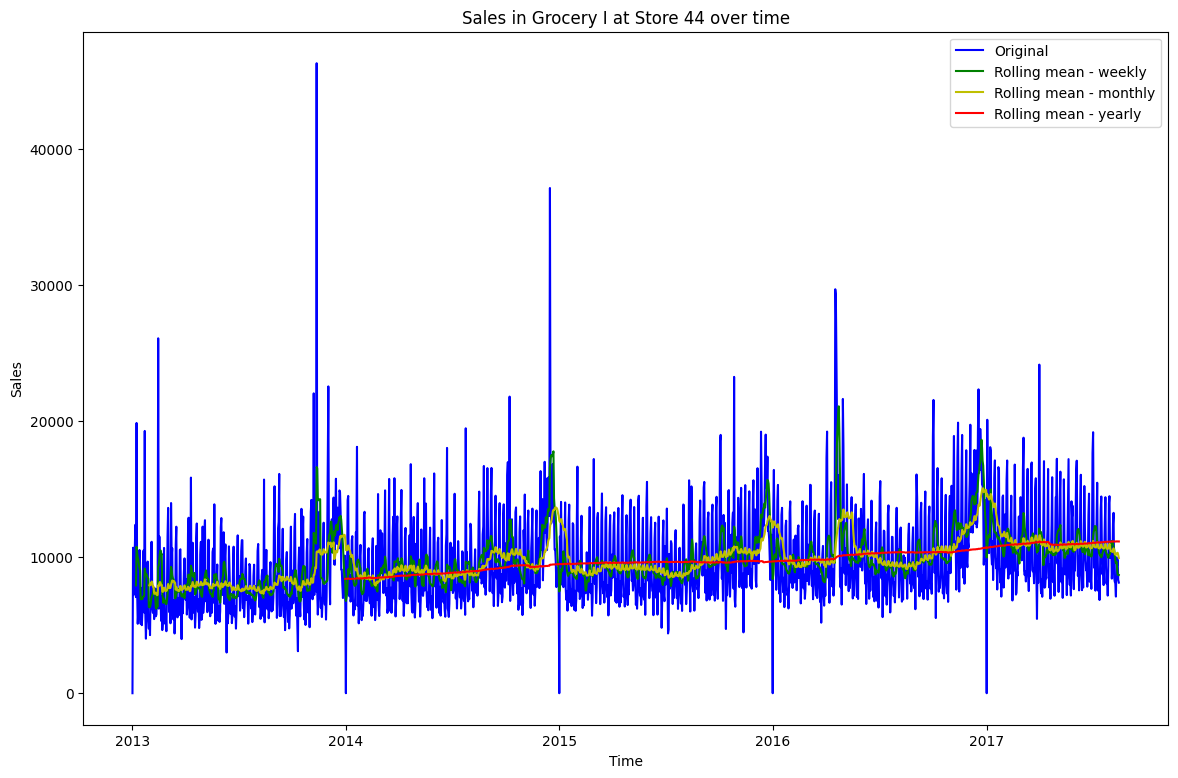

In [9]:
figure(figsize=(14,9), dpi=100)
plt.plot(grocI44['sales'],color='b', label='Original')
plt.plot(grocI44['sales'].rolling(7).mean(),color='g', label='Rolling mean - weekly')
plt.plot(grocI44['sales'].rolling(30).mean(),color='y', label='Rolling mean - monthly')

plt.plot(grocI44['sales'].rolling(365).mean(),color='r', label='Rolling mean - yearly')

plt.legend()
plt.title("Sales in Grocery I at Store 44 over time")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

### 3.0 Stationarity and differencing<a id='3.0'></a>

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed.16 Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. 

Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

As well as the time plot of the data, the ACF plot is also useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly. 

#### 3.1 Base Autocorrelation<a id='3.1'></a>

We can start the process of determining whether and how to difference the data by visualizing the unmodified ACF and PACF.

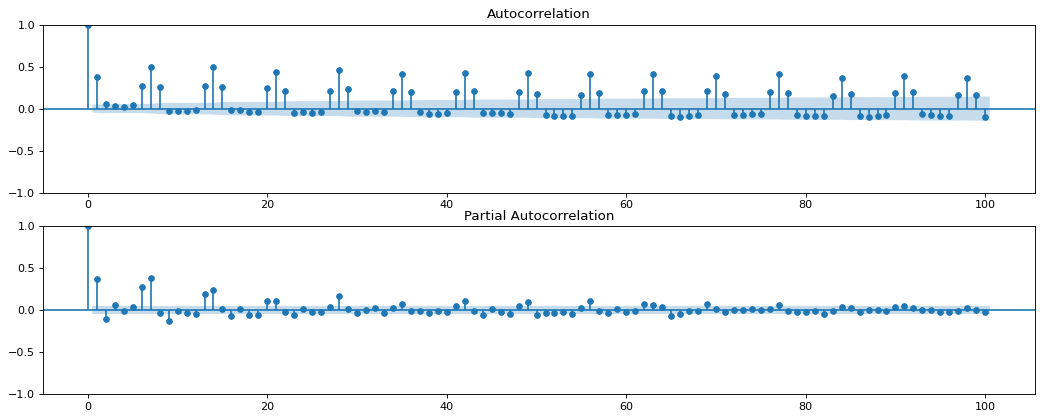

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6), dpi= 80)
plot_acf(grocI44['sales'], ax=ax1, lags=100)
plot_pacf(grocI44['sales'], ax=ax2, lags=100);


There is a strong and obvious weekly seasonality to this data, judging by the correlation on lag 7 and future multiples of 7 - persistent 7-day spikes in the ACF.

Therefore, due to a percieved lack of stationarity, we will need to do some form of differencing.

"To distinguish seasonal differences from ordinary differences, we sometimes refer to ordinary differences as “first differences”, meaning differences at lag 1.

Sometimes it is necessary to take both a seasonal difference and a first difference to obtain stationary data. 

First differences are the change between one observation and the next. Seasonal differences are the change between one year to the next.

One way to determine more objectively whether differencing is required is to use a unit root test. These are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required." [3]

[3] https://otexts.com/fpp3/stationarity.html

#### 3.2 Augmented Dickey-Fuller<a id='3.2'></a>

According to the statsmodels documentation [4], "The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation."

[4] https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Null Hypothesis (H0): The time series has a unit root, meaning it is non-stationary. There exists a time dependent structure.

Alternate Hypothesis (H1): The time series does not have a unit root, meaning it is stationary. There is not a time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data is not stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data is stationary.


In [11]:
adfuller(grocI44['sales'], autolag='AIC')

(-4.932996675785276,
 3.0067619507909915e-05,
 22,
 1665,
 {'1%': -3.434283579780684,
  '5%': -2.863277451883613,
  '10%': -2.5676949772294817},
 30980.030707750837)

Augmented Dickey Fuller test shows that there is stationarity in this time series, with a p-value of 0.00003. The test statistic of -4.93 is considerably below the 1% critical value of -3.43, therefore we can reject the null hypothesis with high confidence.

The intuition behind the test is that if the series is characterised by a unit root process then the lagged level of the series (y_{t-1}) will provide no relevant information in predicting the change in y_t besides the one obtained in the lagged changes (Δ y_{t − k}). In this case the null hypothesis of γ = 0 is rejected and no unit root is present.   [Wikipedia]


#### 3.3 KPSS stationarity test<a id='3.3'></a>

In [12]:
kpss(grocI44['sales'], regression='c')

(4.715616782293408,
 0.01,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

KPSS test shows that there is *not* stationarity in this time series, with a p-value of 0.01 or less.The test statistic of 4.71 is considerably above the 1% critical value of 0.739, therefore we can reject the null hypothesis with high confidence.

The point of KPSS is to test the null hypothesis that an observable series is trend-stationary (stationary around a deterministic trend). The series is expressed as the sum of deterministic trend, random walk, and stationary error, and the test is the Lagrange multiplier test of the hypothesis that the random walk has zero variance. KPSS-type tests are intended to complement unit root tests, such as the Dickey–Fuller tests. By testing both the unit root hypothesis and the stationarity hypothesis, one can distinguish series that appear to be stationary, series that appear to have a unit root, and series for which the data (or the tests) are not sufficiently informative to be sure whether they are stationary or integrated.  [Wikipedia]


What we realize after performing each of these tests is that there is a contradictory-seeming conclusion over this series' stationarity (ADF implies that it is stationary, KPSS implies that it is not stationary).

#### 3.4 Stationarity function<a id='3.4'></a>

Here is a function that can determine if the ADF and KPSS tests produce conflicting results, for future use.

In [13]:
def stationarity_testing(tsdf):
    
    dftest = adfuller(tsdf, autolag='AIC')
    df_p_val = dftest[1]
    kpss(tsdf, regression='c')
    kpss_p_val = kpss(tsdf, regression='c')[1]
    
    if df_p_val > 0.05:
        adf_det = "Not Stationary"
    else:
        adf_det = "Stationary"
    if kpss_p_val < 0.05:
        kpss_det = "Not Stationary"
    else:
        kpss_det = "Stationary"
        
    if adf_det == kpss_det:
        det = "not conflicting"
    else:
        det = "conflicting"
    
    
    print("ADF p value is {}\nKPSS p value is {}\n".format(df_p_val,kpss_p_val))
    print("ADF implies that the series is {}\nKPSS implies that the series is {}\n".format(adf_det,kpss_det))
    print("These test results are {}.".format(det))
    

Testing the Store 44 Grocery I sales data

In [14]:
stationarity_testing(grocI44['sales'])

ADF p value is 3.0067619507909915e-05
KPSS p value is 0.01

ADF implies that the series is Stationary
KPSS implies that the series is Not Stationary

These test results are conflicting.


***<u>If the ADF test does not find a unit root, but the KPSS test does, the series is difference-stationary: it requires differencing.</u>***

#### 3.5 Seasonal stationarity testing<a id='3.5'></a>

We must determine the number of differences required for a seasonally stationary series.

"Osborn-Chui-Smith-Birchenhall OCSB Test:

    Null hypothesis: the series contains a seasonal unit root
    It uses a Dickey-Fuller type regression.

Canova-Hansen Test for Seasonal Stability:

    Null hypothesis: the seasonal pattern is stable over time" [5]

[5] https://towardsdatascience.com/when-a-time-series-only-quacks-like-a-duck-10de9e165e

In [15]:
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import OCSBTest, CHTest

In [16]:
n_adf = ndiffs(grocI44['sales'], test = "adf")
n_kpss = ndiffs(grocI44['sales'], test = "kpss")
n_diffs = {"ADF ndiff":n_adf, "KPSS ndiff":n_kpss}
print("recommended order of first differencing for original data:")
[print(key, ":", value) for key,value in n_diffs.items()];

recommended order of first differencing for original data:
ADF ndiff : 0
KPSS ndiff : 1


In [17]:
# time series before first differencing
# OCSB test that returns the recommended order of seasonal differencing:
n_ocsb = OCSBTest(m=7, max_lag=7,lag_method='aicc').estimate_seasonal_differencing_term(grocI44['sales'])


# CH test that returns the recommended order of seasonal differencing:
n_ch = CHTest(m=7).estimate_seasonal_differencing_term(grocI44['sales'])


# seasonal differencing recommendation:
print("time series before first differencing -")
n_seasdiffs = {"recommended order of seasonal differencing":"", "OCSB recommendation":n_ocsb, "nCH recommendation":n_ch}
[print(key, ":", value) for key,value in n_seasdiffs.items()];

time series before first differencing -
recommended order of seasonal differencing : 
OCSB recommendation : 0
nCH recommendation : 1


The OCSB does not identify a need for seasonal differencing, similar to the ACF for first differencing.
However, the CH test does recommend 1 order of seasonal differencing, similar to KPSS for first differencing.

Since we observed the data as having a strong weekly periodicity, and the frequency is daily, then we will use a differencing of 7 to remove seasonal effects, then retest.

In [18]:
# ADF and KPSS tests after first differencing AND seasonal differencing:
# use the larger recommended order of first and seasonal differencing, respectively

df_diff7 = grocI44['sales'].diff(7).dropna()


# after first AND seasonal differencing: compare ADF, KPSS, OCSB and CH results
n_adf7 = ndiffs(df_diff7, test="adf")
n_kpss7 = ndiffs(df_diff7, test="kpss")
n_ocsb7 = OCSBTest(m=7, max_lag=7,lag_method='aicc').estimate_seasonal_differencing_term(df_diff7)
n_ch7 = CHTest(m=7).estimate_seasonal_differencing_term(df_diff7)

print("after 1 round of differencing - do we need more?")
n_diffs = {"recommended additional differencing":"", "ADF first":n_adf7, "KPSS first":n_kpss7, 
    "OCSB seasonal":n_ocsb7, "CH seasonal":n_ch7}
[print(key, ":", value) for key,value in n_diffs.items()];


after 1 round of differencing - do we need more?
recommended additional differencing : 
ADF first : 0
KPSS first : 0
OCSB seasonal : 0
CH seasonal : 0


This is excellent, as all four of our tests imply that this 7-day seasonal differencing is sufficient to make the series stationary.

According to Hyndman, "If the data have a strong seasonal pattern, we recommend that seasonal differencing be done first, because the resulting series will sometimes be stationary and there will be no need for a further first difference. If first differencing is done first, there will still be seasonality present.

Beware that applying more differences than required will induce false dynamics or autocorrelations that do not really exist in the time series. Therefore, do as few differences as necessary to obtain a stationary series." [3]

Therefore, after differencing for the weekly seasonality and finding it sufficient, we will forego first-order differencing at this time.

#### 3.6 Seasonally decomposition<a id='3.6'></a>

We will visualize the decomposed series with one 7-day differencing applied. [6]

[6] https://medium.com/geekculture/time-series-analysis-using-arima-model-with-python-afe4b41bbec8

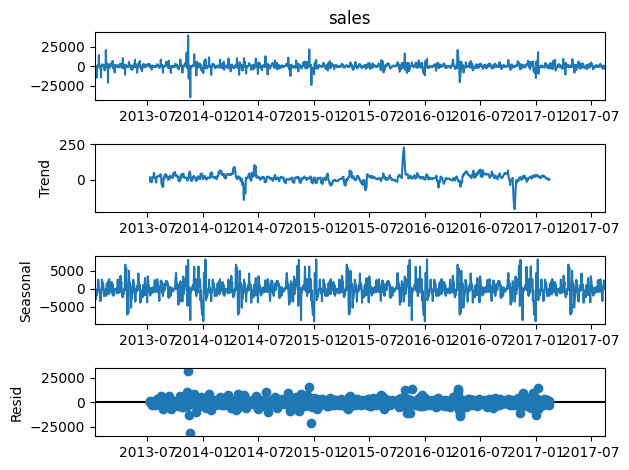

In [19]:
result = seasonal_decompose(grocI44['sales'].diff(7).dropna(),model='additive',period=365)

# Plot the original data, the trend, the seasonality, and the residuals 
result.plot();

While it appears that there is more seasonality to investigate (probably yearly and possibly monthly), we will temporarily move forward with creating our base model.

#### 3.7 ACF and PACF on stationary data<a id='3.7'></a>

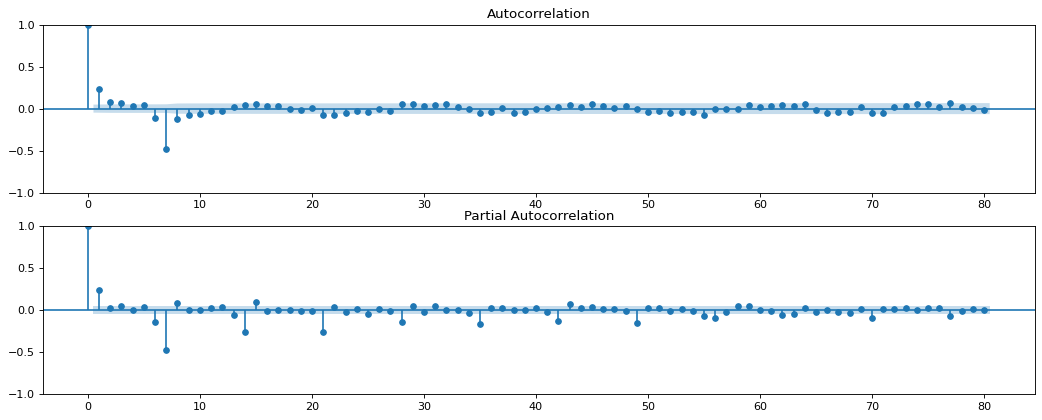

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,6), dpi= 80)
plot_acf(grocI44['sales'].diff(7).dropna(), ax=ax1, lags=80)
plot_pacf(grocI44['sales'].diff(7).dropna(), ax=ax2, lags=80);


The pattern is still visible, but the plots show quick loss of correlation with increasing lags.

How to interpret ACF and PACF plots [7]:

Time series models such as Auto Regression (AR), Moving Averages (MA), or their combinations (ARMA), require you to specify one or more parameters. These can be obtained by looking at ACF and PACF plots.

In a nutshell:

    If the ACF plot declines gradually and the PACF drops instantly, use Auto Regressive model.
    If the ACF plot drops instantly and the PACF declines gradually, use Moving Average model.
    If both ACF and PACF decline gradually, combine Auto Regressive and Moving Average models (ARMA).
    If both ACF and PACF drop instantly (no significant lags), it’s likely you won’t be able to model the time series.

[7] https://towardsdatascience.com/time-series-from-scratch-autocorrelation-and-partial-autocorrelation-explained-1dd641e3076f

My initial inclination is to use a combination of Auto Regressive and Moving Average models.

### 4.0 Baseline ARIMA<a id='4.0'></a>

We will use the ARIMA algorithm to fit our data and make predictions, but first we need to split the data into training and testing sets for analysis.

#### 4.1 Train/Test split<a id='4.1'></a>

In [21]:
data = grocI44['sales']
tss = TimeSeriesSplit(n_splits=3)
X_tr = []
X_te = []

#X_train, X_test = tss.split(data)
for fold, (train_index, test_index) in enumerate(tss.split(data)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", min(train_index)," ... ",max(train_index), "\n",
          "TEST indices:", min(test_index)," ... ",max(test_index))
    X_tr.append(data[train_index])
    X_te.append(data[test_index])


Fold: 0
TRAIN indices: 0  ...  421 
 TEST indices: 422  ...  843
Fold: 1
TRAIN indices: 0  ...  843 
 TEST indices: 844  ...  1265
Fold: 2
TRAIN indices: 0  ...  1265 
 TEST indices: 1266  ...  1687


##### 4.1.1 Metrics of evaluation<a id='4.1.1'></a>

For the purpose of comparing various models, we will simply train using the final fold (having the most information), and compare predictions of the final test epoch with the actual final test data.

We will use mean absolute percentage error (MAPE) and R^2 to evaluate model performance.

In [22]:
def mape(y_true, y_pred):
    
    mapes = []
    
    for e in range(len(y_true)):
        if y_true[e]!=0:
            mapes.append(np.abs((y_true[e] - y_pred[e]) / y_true[e]))
        else:
            mapes.append(np.abs((y_true[e] - y_pred[e] / np.mean(y_true))))
    
    mape_stat = round(np.mean(mapes) * 100,2)
    return mape_stat


def r2(y_true, y_pred):
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_true, y_pred)
    r2_val = round(r_value**2,5)
    return r2_val

#### 4.2 ARIMA with basic p,d,q<a id='4.2'></a>

Before using all of our stationarity analysis, we will run a very basic ARIMA with p,d,q of (1,1,1).

In [23]:
model_ARIMA_basic = ARIMA(X_tr[2], order=(1,1,1))
model_ARIMA_basic_fit = model_ARIMA_basic.fit()
print(model_ARIMA_basic_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1266
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12045.918
Date:                Wed, 12 Apr 2023   AIC                          24097.835
Time:                        10:45:49   BIC                          24113.264
Sample:                    01-01-2013   HQIC                         24103.632
                         - 06-19-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2820      0.017     16.630      0.000       0.249       0.315
ma.L1         -0.9826      0.005   -200.150      0.000      -0.992      -0.973
sigma2      1.091e+07   4.27e-10   2.56e+16      0.0

##### 4.2.1 Plotting the basic ARIMA residuals<a id='4.2.1'></a>

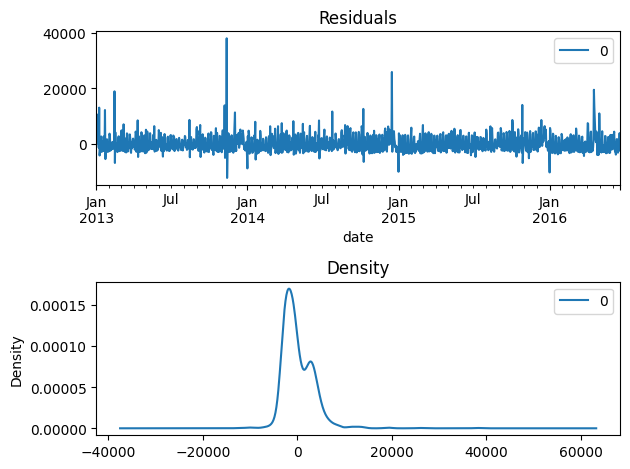

In [24]:
residuals_ARIMA_basic = pd.DataFrame(model_ARIMA_basic_fit.resid)
fig, ax = plt.subplots(2,1)
residuals_ARIMA_basic.plot(title="Residuals", ax=ax[0])
residuals_ARIMA_basic.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show();

##### 4.2.2 Plotting the basic ARIMA predictions<a id='4.2.2'></a>

In [25]:
model_ARIMA_basic_pred = model_ARIMA_basic_fit.get_forecast(len(X_te[2]), alpha=0.05)

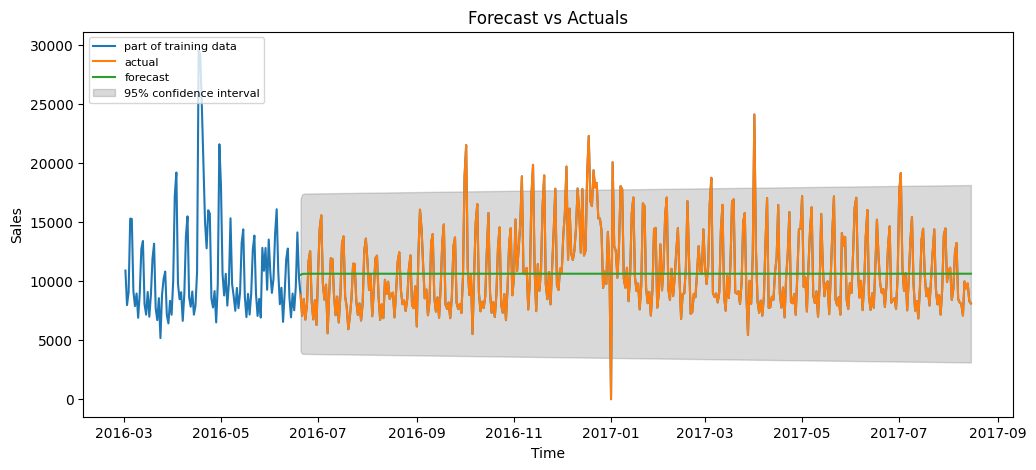

In [26]:
# Make as pandas series
lower_series = model_ARIMA_basic_pred.conf_int(alpha=0.05).iloc[:,0]
upper_series = model_ARIMA_basic_pred.conf_int(alpha=0.05).iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(X_te[1], label='actual', color='b')
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(model_ARIMA_basic_pred.predicted_mean, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15,label="95% confidence interval")
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### 4.2.3 Evaluating basic ARIMA<a id='4.2.3'></a>

In [27]:
model_ARIMA_basic_name = 'Basic_ARIMA'
model_ARIMA_basic_mape = mape(X_te[2],model_ARIMA_basic_pred.predicted_mean)
model_ARIMA_basic_r2 = r2(X_te[2],model_ARIMA_basic_pred.predicted_mean)

In [28]:
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_ARIMA_basic_name,model_ARIMA_basic_mape,model_ARIMA_basic_r2))

For Basic_ARIMA model:
MAPE = 24.96
R^2 = 0.00222


#### 4.3 ARIMA with pre-figured p,d,q<a id='4.3'></a>

Based on the ACF and PACF, our next model will be a seasonal ARIMA with the order (1,0,1), with seasonal order being (0,1,1,7) to account for the weekly seasonality. We can use a loop to double-check that these parameters are optimal (using AIC as the test metric).

In [29]:
import itertools

In [30]:
p = range(0,3)
d = range(0,3)
q = range(0,3)
s = range(7,8)
pdq = list(itertools.product(p,d,q,s)) # gets all possible combinations of p, d, and q 
combs = {}
aics = []

for combination in pdq:
    try:
        
        model = SARIMAX(X_tr[2], order=(6,0,2), seasonal_order=combination).fit()
        #print(model.aic)
        combs.update({model.aic : [combination]})
        aics.append(model.aic)
        print("{}: {}".format(combination,model.aic))
    except:
        continue

best_aic = min(aics)
print(best_aic)
print(combs[best_aic][0])

(0, 0, 0, 7): 23980.331362435652
(0, 0, 1, 7): 24011.509087649265
(0, 0, 2, 7): 23958.938557440517
(0, 1, 0, 7): 24003.83697245501
(0, 1, 1, 7): 23669.963872400916
(0, 1, 2, 7): 23672.319867960054
(0, 2, 0, 7): 24942.259353175272
(0, 2, 1, 7): 24555.13143515278
(0, 2, 2, 7): 24459.39458342336
(1, 0, 0, 7): 24100.034473740605
(1, 0, 1, 7): 23747.385883899573
(1, 0, 2, 7): 23748.91108554683
(1, 1, 0, 7): 23847.893135329687
(1, 1, 1, 7): 23672.466077103345
(1, 1, 2, 7): 23673.34688933773
(1, 2, 0, 7): 24732.866351470464
(1, 2, 1, 7): 24508.47041701803
(1, 2, 2, 7): 24465.02328362847
(2, 0, 0, 7): 23898.428881626463
(2, 0, 2, 7): 23738.421966665996
(2, 1, 0, 7): 23805.475638735174
(2, 1, 1, 7): 23673.096558324687
(2, 1, 2, 7): 23675.945279939784
(2, 2, 0, 7): 24653.695980696684
(2, 2, 1, 7): 24494.44229031106
(2, 2, 2, 7): 24465.126683173898
23669.963872400916
(0, 1, 1, 7)


In [31]:
model_SARIMA = SARIMAX(X_tr[2], order=(1,0,1),seasonal_order=(0,1,1,7))
model_SARIMA_fit = model_SARIMA.fit()
print(model_SARIMA_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1266
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood              -11744.651
Date:                           Wed, 12 Apr 2023   AIC                          23497.302
Time:                                   10:49:03   BIC                          23517.854
Sample:                               01-01-2013   HQIC                         23505.026
                                    - 06-19-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8595      0.029     30.085      0.000       0.803       0.915
ma.L1         -0.6560      0.034    -19.031

##### 4.3.1 Plotting the seasonal ARIMA residuals<a id='4.3.1'></a>

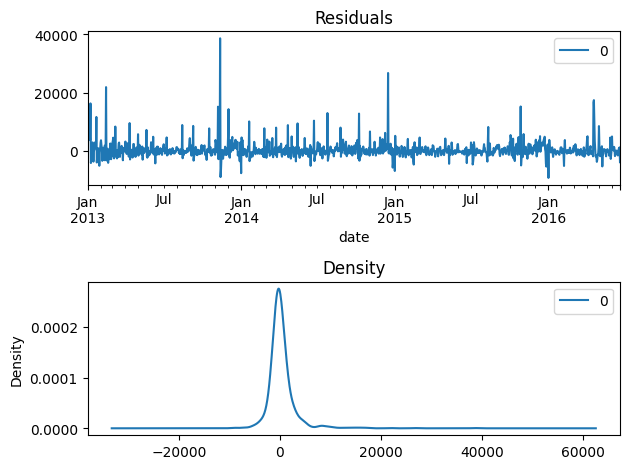

In [32]:
residuals_SARIMA = pd.DataFrame(model_SARIMA_fit.resid)
fig, ax = plt.subplots(2,1)
residuals_SARIMA.plot(title="Residuals", ax=ax[0])
residuals_SARIMA.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show();

##### 4.3.2 Plotting the seasonal ARIMA predictions<a id='4.3.2'></a>

In [33]:
model_SARIMA_pred = model_SARIMA_fit.get_forecast(len(X_te[2]), alpha=0.05)

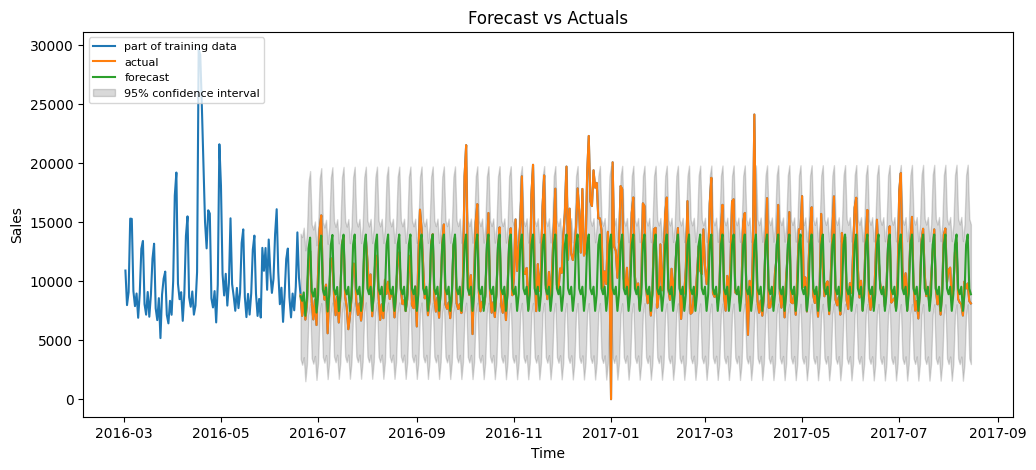

In [34]:
# Make as pandas series
lower_series = model_SARIMA_pred.conf_int(alpha=0.05).iloc[:,0]
upper_series = model_SARIMA_pred.conf_int(alpha=0.05).iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(X_te[1], label='actual', color='b')
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(model_SARIMA_pred.predicted_mean, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15,label="95% confidence interval")
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### 4.3.3 Evaluating seasonal ARIMA<a id='4.3.3'></a>

In [35]:
model_SARIMA_name = 'Seasonal_ARIMA'
model_SARIMA_mape = mape(X_te[2],model_SARIMA_pred.predicted_mean)
model_SARIMA_r2 = r2(X_te[2],model_SARIMA_pred.predicted_mean)

In [36]:
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_SARIMA_name,model_SARIMA_mape,model_SARIMA_r2))

For Seasonal_ARIMA model:
MAPE = 13.93
R^2 = 0.51081


#### 4.4 Problem with the first models<a id='4.4'></a>

Because the seasonal ARIMA only accounts for one periodicity in the data (we chose 7 for weekly), there is unlikely to be accuracy when encountering other periodicities (such as biweekly, monthly, and yearly).

To illustrate the problem, we can add a half year to the forcast horizon, and no significant pattern changes will be seen in our predictions.

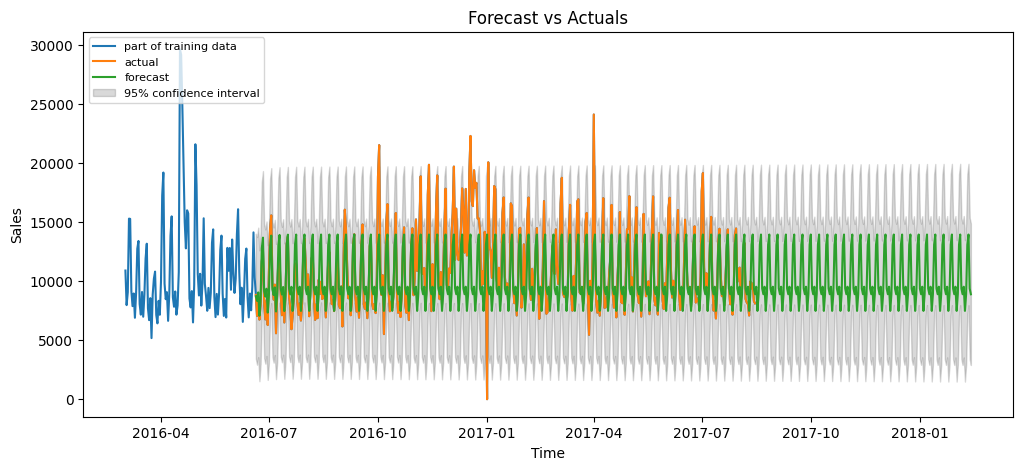

In [37]:
model_SARIMA_pred2 = model_SARIMA_fit.get_forecast(len(X_te[2])+182, alpha=0.05)
# Make as pandas series
lower_series = model_SARIMA_pred2.conf_int(alpha=0.05).iloc[:,0]
upper_series = model_SARIMA_pred2.conf_int(alpha=0.05).iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(X_te[1], label='actual', color='b')
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(model_SARIMA_pred2.predicted_mean, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15,label="95% confidence interval")

plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

The pattern of the predicted sales remains fairly constant no matter the length of the prediction window. There is a known significant annual uptick in sales the week prior to Christmas. However, due to the unaccounted for biweekly, monthly, and yearly seasonalities, the sales pattern is stuck on repeat.

#### 4.5 Multi-seasonal time series analysis<a id='4.5'></a>

One solution is using a multi-seasonal model. We can break down the sales data even further by removing the many periodicities involved, then account for all of them when forecasting.

In [38]:
periods = [7,14,30,365]

mstl = MSTL(X_tr[2], periods=periods)
res = mstl.fit()

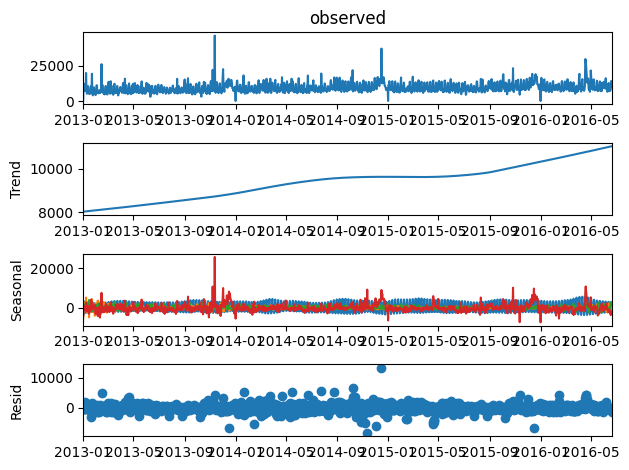

In [39]:
res.plot()
plt.tight_layout()
plt.show()

Since the graph is small and complex, we can break down the different 'Seasonal' plots into individual visualizations

##### 4.5.1 Seasonal breakdown<a id='4.5.1'></a>

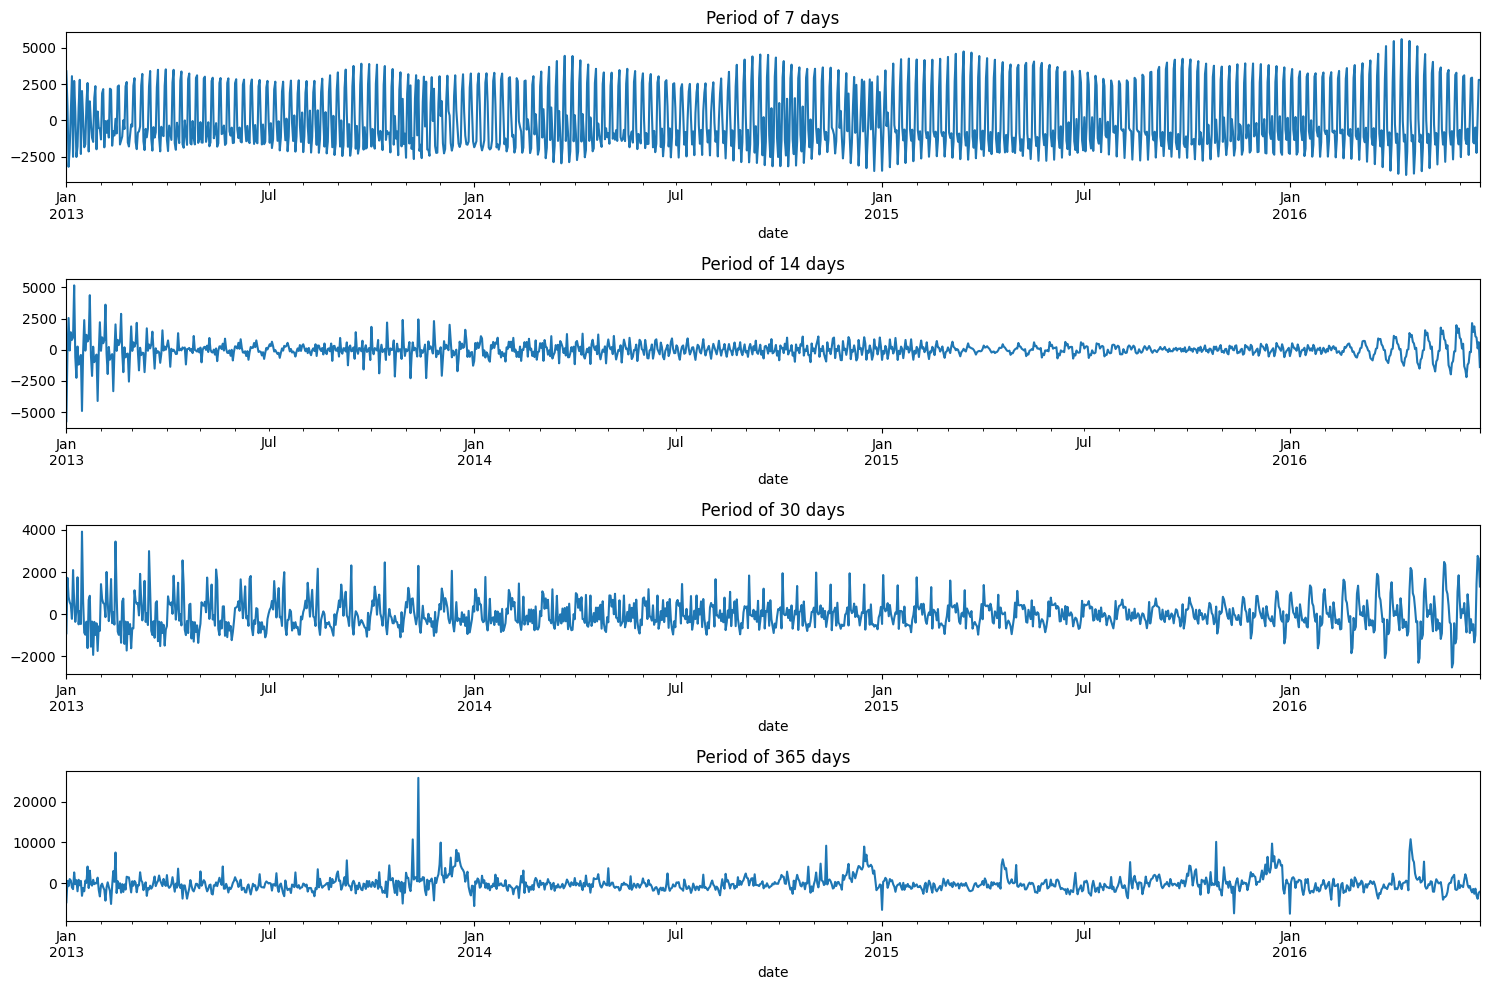

In [40]:
fig, ax = plt.subplots(4,1,figsize=(15, 10))
for e,i in enumerate(res.seasonal.columns):
    res.seasonal[i].plot(title="Period of {} days".format(periods[e]),ax=ax[e])
fig.tight_layout()
plt.show();

Each of these periods has a clear and present trend that is now removed from the data. It is noticable how clean the trend is now.

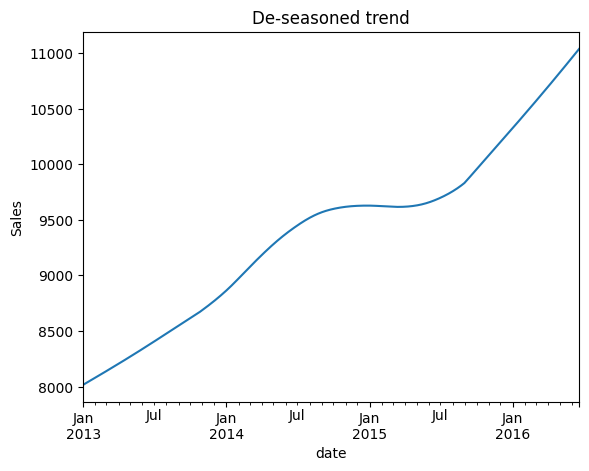

In [41]:
res.trend.plot(title="De-seasoned trend")
plt.ylabel('Sales')
fig.tight_layout()
plt.show();

#### 4.6 TBATS<a id='4.6'></a>

According to sktime documentation [8],<br>
TBATS is acronym for:

-Trigonometric seasonality<br>
-Box-Cox transformation<br>
-ARMA errors<br>
-Trend<br>
-Seasonal components<br>

TBATS was designed to forecast time series with multiple seasonal periods.

In TBATS, a Box-Cox transformation is applied to the original time series, and then this is modelled as a linear combination of an exponentially smoothed trend, a seasonal component and an ARMA component. The seasonal components are modelled by trigonometric functions via Fourier series. TBATS conducts some hyper-parameter tuning using AIC.

[8] https://sktime.readthedocs.io/en/stable/api_reference/auto_generated/sktime.forecasting.tbats.TBATS.html?highlight=tbats#sktime.forecasting.tbats.TBATS.predict

##### 4.6.1 Fitting the model<a id='4.6.1'></a>

In [42]:
forecaster = TBATS(use_box_cox=True,
                  use_trend=False,
                  use_damped_trend=False,
                  sp=[7,14,30,365])

In [43]:
forecaster.fit(X_tr[2])

TBATS(sp=[7, 14, 30, 365], use_box_cox=True, use_damped_trend=False,
      use_trend=False)

In [44]:
y_pred_TBATS = forecaster.predict(pd.date_range(start=min(X_te[2].index), periods=len(X_te[2]), freq='D'))
y_pred_TBATS_qs = forecaster.predict_quantiles(fh=None, X=None, alpha=None)

##### 4.6.2 Plotting the multi-seasonal TBATS predictions<a id='4.6.2'></a>

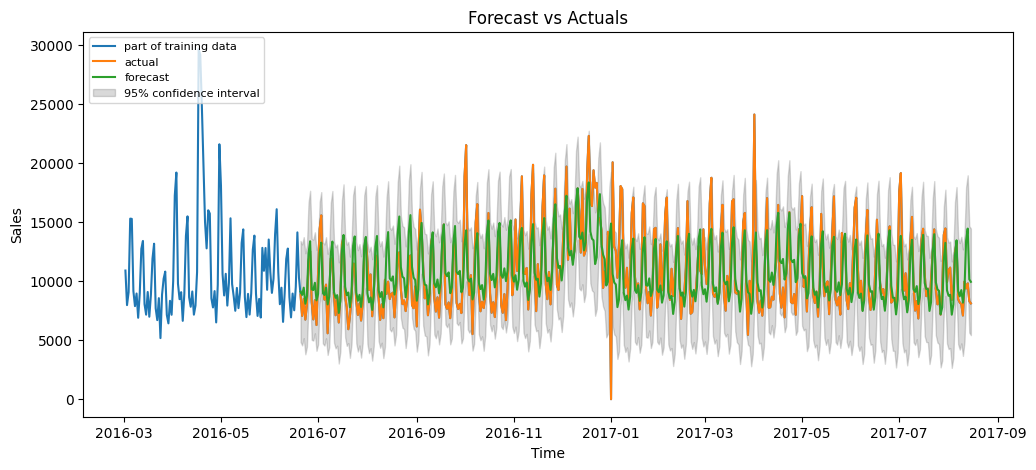

In [45]:
# Make as pandas series
lower_series = y_pred_TBATS_qs.iloc[:,0]
upper_series = y_pred_TBATS_qs.iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(X_te[1], label='actual', color='b')
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(y_pred_TBATS, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15,label="95% confidence interval")
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

This graph passes the "eye test" easily. We see that there is a weekly pattern as before, but now the other seasonalities are accounted for, with the end-of-year trend increase visible.

##### 4.6.3 Evaluating multi-seasonal TBATS<a id='4.6.3'></a>

In [46]:
model_TBATS_name = 'TBATS'
model_TBATS_mape = mape(X_te[2],y_pred_TBATS)
model_TBATS_r2 = r2(X_te[2],y_pred_TBATS)

In [47]:
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_TBATS_name,model_TBATS_mape,model_TBATS_r2))

For TBATS model:
MAPE = 15.42
R^2 = 0.5561


These results seem to be very good. While MAPE it not quite as low as that of the seasonal ARIMA, it is considerably better than the basic ARIMA. The R^2 of the TBATS is better than either ARIMA model.

One step that can be taken with TBATS is to use more precise seasonal periods. One year is closer to 365.25 days. One month is closer to 30.43 days. We can rerun the TBATS with thse updated parameters and compare results.

In [50]:
start_time = datetime.now()
#code to time

forecaster2 = TBATS(use_box_cox=True,
                  use_trend=False,
                  use_damped_trend=False,
                  sp=[7,14,30.43,365.25])


forecaster2.fit(X_tr[2])


y_pred_TBATS2 = forecaster2.predict(pd.date_range(start=min(X_te[2].index), periods=len(X_te[2]), freq='D'))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:27.218516


In [51]:
y_pred_TBATS_qs2 = forecaster2.predict_quantiles(fh=None, X=None, alpha=None)

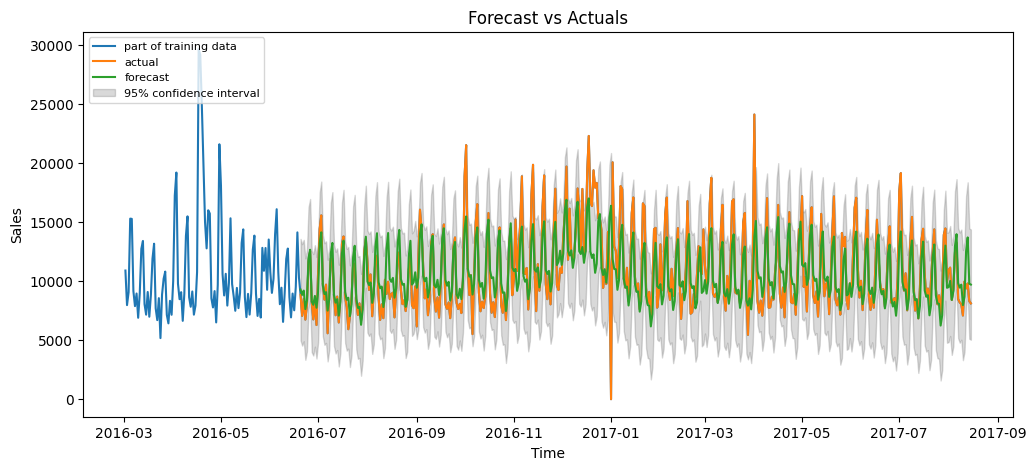

In [52]:
# Make as pandas series
lower_series = y_pred_TBATS_qs2.iloc[:,0]
upper_series = y_pred_TBATS_qs2.iloc[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(X_te[1], label='actual', color='b')
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(y_pred_TBATS2, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15,label="95% confidence interval")
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [53]:
model_TBATS_name2 = 'TBATS2'
model_TBATS_mape2 = mape(X_te[2],y_pred_TBATS2)
model_TBATS_r22 = r2(X_te[2],y_pred_TBATS2)

In [54]:
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_TBATS_name2,model_TBATS_mape2,model_TBATS_r22))

For TBATS2 model:
MAPE = 13.81
R^2 = 0.61295


These are the best results so far. Both MAPE and R^2 are the best of the models.

#### 4.7 Comparing model results<a id='4.7'></a>

In [55]:
model_names = [model_ARIMA_basic_name,model_SARIMA_name,model_TBATS_name,model_TBATS_name2]
mapes = [model_ARIMA_basic_mape,model_SARIMA_mape,model_TBATS_mape,model_TBATS_mape2]
r2s = [model_ARIMA_basic_r2,model_SARIMA_r2,model_TBATS_r2,model_TBATS_r22]

In [56]:
np.array([model_names,mapes,r2s])

array([['Basic_ARIMA', 'Seasonal_ARIMA', 'TBATS', 'TBATS2'],
       ['24.96', '13.93', '15.42', '13.81'],
       ['0.00222', '0.51081', '0.5561', '0.61295']], dtype='<U32')

In [57]:
compare_models = pd.DataFrame(np.array([model_names,mapes,r2s]).T,columns=['model_names','MAPE','R^2'])

In [58]:
compare_models

,model_names,MAPE,R^2
0,Basic_ARIMA,24.96,0.00222
1,Seasonal_ARIMA,13.93,0.51081
2,TBATS,15.42,0.5561
3,TBATS2,13.81,0.61295


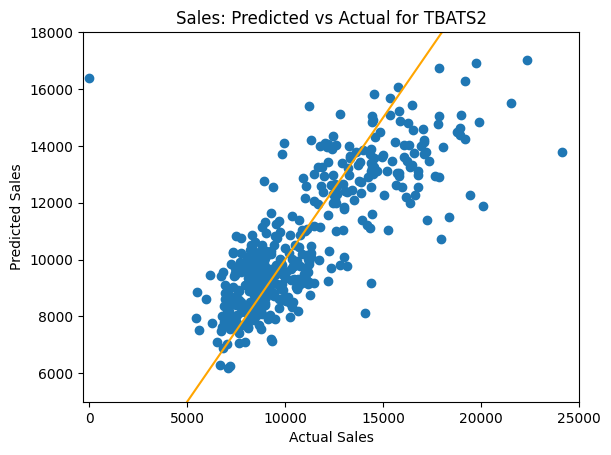

In [59]:
plt.scatter(X_te[2],y_pred_TBATS2)
plt.title('Sales: Predicted vs Actual for TBATS2')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.axline((0, 0), slope=1, color = 'orange')
plt.xlim(-300,25000)
plt.ylim(5000,18000)
plt.show();

In [60]:
residuals_TBATS2 = X_te[2]-y_pred_TBATS2

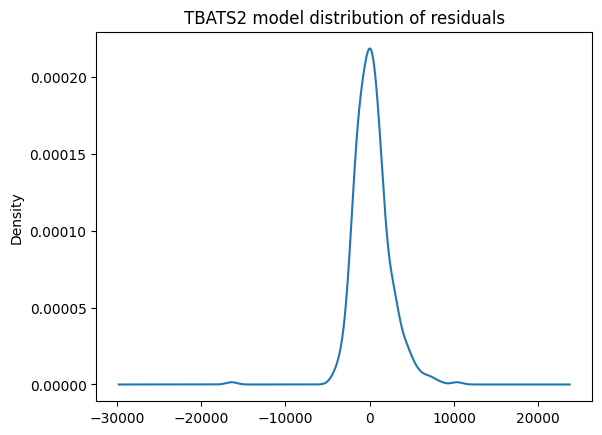

In [61]:

residuals_TBATS2.plot(kind='kde', title='TBATS2 model distribution of residuals')
plt.show();

The result is good, but our goals are to get the MAPE value to be as low as possible, and the R-squared value to be as high as possible.

While we do have more information that could be included in modeling, like transaction and oil price data, these variables cannot be known ahead of time, and would need to be predicted in order to be used as part of forecasting in any models. Another option which we will not pursue is utilizing time-lagged information as a varibale. This could be an option in a future analysis of this data, but for now we will focus on predictions of the target based on known information.

Using already-known data will be the choice moving forward. We do still have promotional data that is available through the entire dataset.


### 5.0 Analysis inclusive of exogenous variables<a id='5.0'></a>

Unfortunately, the TBATS forecasting algorithm is not able to accomodate exogenous variables. Therefore, as a next step, we can use ARIMA with selected exogenous variables as predictors. We can also use Fourier transformations of the sales data (as exogenous variables) to approximate the effect of multiple seasonality in our data.

In [62]:
data = grocI44['sales'].copy()

#### 5.1 Seasonality as exogenous variables using Fourier transformation<a id='5.1'></a>

We are able to manually compute Fourier terms:

In [361]:
# prepare Fourier terms
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin30'] = np.sin(2 * np.pi * exog.index.day / 30.43)
exog['cos30'] = np.cos(2 * np.pi * exog.index.day / 30.43)
exog = exog.drop(columns=['date'])

In [713]:
exog.head()

,sin365,cos365,sin30,cos30
date,,,,
2013-01-01,0.017202,0.999852,0.205016,0.978759
2013-01-02,0.034398,0.999408,0.401322,0.915937
2013-01-03,0.051584,0.998669,0.580579,0.814204
2013-01-04,0.068755,0.997634,0.735172,0.677881
2013-01-05,0.085906,0.996303,0.858532,0.512760


However, the pmdarima package will compute Fourier terms for us, saving many lines of code:

In [65]:
from pmdarima.preprocessing import FourierFeaturizer

In [323]:
ff365 = FourierFeaturizer(365.25,1)
y_prime365, ff365_fit = ff365.fit_transform(data)
ff30 = FourierFeaturizer((365.25/12),1)
y_prime30, ff30_fit = ff30.fit_transform(data)
ff14 = FourierFeaturizer((14),1)
y_prime14, ff14_fit = ff14.fit_transform(data)
ff15 = FourierFeaturizer(((365.25/12))/2,1)
y_prime15, ff15_fit = ff15.fit_transform(data)

In order to account more precisely for the biweekly public employee paycheck distribution, I added another period of half-month to the data.

In [324]:
exog = pd.DataFrame({'date': data.index})

ff365_fit= ff365_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
ff30_fit= ff30_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
ff14_fit= ff14_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))
ff15_fit= ff15_fit.set_index(pd.PeriodIndex(exog['date'], freq='D'))

exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
exog = pd.concat([exog,ff365_fit,ff30_fit
                  ,ff14_fit
                  ,ff15_fit],
                 axis=1)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(X_tr[2]))]
exog_to_test = exog.iloc[(len(X_tr[2])):]

In [325]:
exog

,FOURIER_S365-0,FOURIER_C365-0,FOURIER_S30-0,FOURIER_C30-0,FOURIER_S14-0,FOURIER_C14-0,FOURIER_S15-0,FOURIER_C15-0
date,,,,,,,,
2013-01-01,0.017202,0.999852,0.204966,0.978769,0.433884,0.900969,0.401229,0.915978
2013-01-02,0.034398,0.999408,0.401229,0.915978,0.781831,0.623490,0.735034,0.678031
2013-01-03,0.051584,0.998669,0.580455,0.814292,0.974928,0.222521,0.945320,0.326144
2013-01-04,0.068755,0.997634,0.735034,0.678031,0.974928,-0.222521,0.996751,-0.080549
2013-01-05,0.085906,0.996303,0.858402,0.512978,0.781831,-0.623490,0.880683,-0.473706
...,...,...,...,...,...,...,...,...
2017-08-11,-0.640038,-0.768343,0.886726,-0.462295,0.974926,-0.222527,-0.819858,-0.572568
2017-08-12,-0.653160,-0.757220,0.773146,-0.634228,0.781827,-0.623495,-0.980702,-0.195509
2017-08-13,-0.666089,-0.745872,0.626736,-0.779232,0.433878,-0.900972,-0.976745,0.214405


#### 5.2 Adding promotional item information<a id='5.2'></a>

In [326]:
exog['promo'] = grocI44['onpromotion'].values
exog

,FOURIER_S365-0,FOURIER_C365-0,FOURIER_S30-0,FOURIER_C30-0,FOURIER_S14-0,FOURIER_C14-0,FOURIER_S15-0,FOURIER_C15-0,promo
date,,,,,,,,,
2013-01-01,0.017202,0.999852,0.204966,0.978769,0.433884,0.900969,0.401229,0.915978,0.0
2013-01-02,0.034398,0.999408,0.401229,0.915978,0.781831,0.623490,0.735034,0.678031,0.0
2013-01-03,0.051584,0.998669,0.580455,0.814292,0.974928,0.222521,0.945320,0.326144,0.0
2013-01-04,0.068755,0.997634,0.735034,0.678031,0.974928,-0.222521,0.996751,-0.080549,0.0
2013-01-05,0.085906,0.996303,0.858402,0.512978,0.781831,-0.623490,0.880683,-0.473706,0.0
...,...,...,...,...,...,...,...,...,...
2017-08-11,-0.640038,-0.768343,0.886726,-0.462295,0.974926,-0.222527,-0.819858,-0.572568,38.0
2017-08-12,-0.653160,-0.757220,0.773146,-0.634228,0.781827,-0.623495,-0.980702,-0.195509,39.0
2017-08-13,-0.666089,-0.745872,0.626736,-0.779232,0.433878,-0.900972,-0.976745,0.214405,41.0


Split the exogenous data into the training and testing portions

In [327]:
exog_to_trainfp = exog.iloc[:(len(X_tr[2]))]
exog_to_testfp = exog.iloc[(len(X_tr[2])):]

#### 5.3 Building our new ARIMAs with exogenous variables<a id='5.3'></a>

We will see how ARIMAs will react to having exogenous variables. First with both Fourier and promotional variables, then with only Fourier and only promotional variables, for comparison.

##### 5.3.1 ARIMAs with both exogenous variables<a id='5.3.1'></a>

In [708]:
start_time = datetime.now()
#code to time

# Fit model
arima_exog_modelfp = pmdARIMA(order = (1,0,1), seasonal_order = (0,1,1,7))


arima_exog_modelfp.fit(X_tr[2], X=exog_to_trainfp.values)

model_ARIMAfp_pred = arima_exog_modelfp.predict(n_periods=len(X_te[2]), X=exog_to_testfp.values)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:08.104719


##### 5.3.2 Plotting the ARIMA with both exogenous variables<a id='5.3.2'></a>

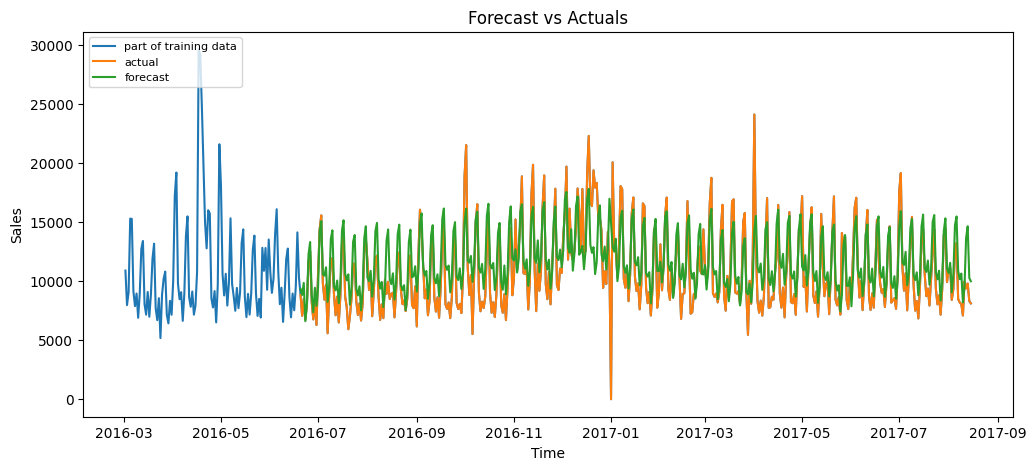

In [709]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(model_ARIMAfp_pred, label='forecast')

plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### 5.3.3 Evaluating ARIMA with both exogenous variables<a id='5.3.3'></a>

In [711]:
model_ARIMAfp_name = 'ARIMA with exogenous variables'
model_ARIMAfp_mape = mape(X_te[2],model_ARIMAfp_pred)
model_ARIMAfp_r2 = r2(X_te[2],model_ARIMAfp_pred)
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_ARIMAfp_name,model_ARIMAfp_mape,model_ARIMAfp_r2))

For ARIMA with exogenous variables model:
MAPE = 16.76
R^2 = 0.64902


This model has a solid R^2 score (the highest we have seen here), with a decent MAPE. However, we have seen a model produce a lower MAPE already.

#### 5.4 ARIMA with only Fourier values as exogenous variables<a id='5.4'></a>

##### 5.4.1 ARIMA with only Fourier values as exogenous variables<a id='5.4.1'></a>

In [218]:
# Fit model
arima_exog_modelf = pmdARIMA(order = (1,0,1), seasonal_order = (0,1,1,7))

In [219]:
arima_exog_modelf.fit(X_tr[2], X=exog_to_trainfp.iloc[:,:-1].values)

ARIMA(order=(1, 0, 1), seasonal_order=(0, 1, 1, 7))

In [220]:
# Forecast
model_ARIMAf_pred = arima_exog_modelf.predict(n_periods=len(X_te[2]),X=exog_to_testfp.iloc[:,:-1])

##### 5.4.2 Plotting the ARIMA with Fourier values as exogenous variables<a id='5.4.2'></a>

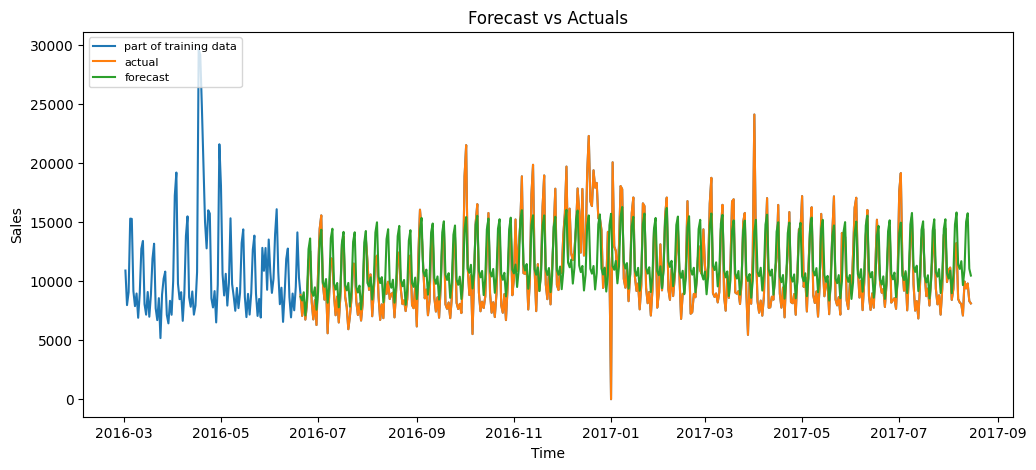

In [221]:

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(X_te[1], label='actual', color='b')
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(model_ARIMAf_pred, label='forecast')

plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### 5.4.3 Evaluating ARIMA with Fourier values as exogenous variables<a id='5.4.3'></a>

In [222]:
model_ARIMAf_name = 'ARIMA with fourier exogenous only'
model_ARIMAf_mape = mape(X_te[2],model_ARIMAf_pred)
model_ARIMAf_r2 = r2(X_te[2],model_ARIMAf_pred)

In [223]:
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_ARIMAf_name,model_ARIMAf_mape,model_ARIMAf_r2))

For ARIMA with fourier exogenous only model:
MAPE = 16.82
R^2 = 0.5666


The result is good, with a lower MAPE score, and a fairly decent R^2 score.

#### 5.5 Promotional values-only ARIMA<a id='5.5'></a>

##### 5.5.1 ARIMA with only promotional values as exogenous variables<a id='5.5.1'></a>

In [80]:
p_to_train = exog.iloc[:(len(X_tr[2])),-1].to_frame()
p_to_test = exog.iloc[(len(X_tr[2])):,-1].to_frame()

In [81]:
# Fit model
arima_exog_modelp = pmdARIMA(order = (1,0,1), seasonal_order = (0,1,1,7))

In [82]:
arima_exog_modelp.fit(X_tr[2], X=p_to_train.values)

ARIMA(order=(1, 0, 1), seasonal_order=(0, 1, 1, 7))

In [83]:
# Forecast
model_ARIMAp_pred = arima_exog_modelp.predict(n_periods=len(X_te[2]),X=p_to_test.values)

##### 5.5.2 Plotting the ARIMA with only promotional values as variables<a id='5.5.2'></a>

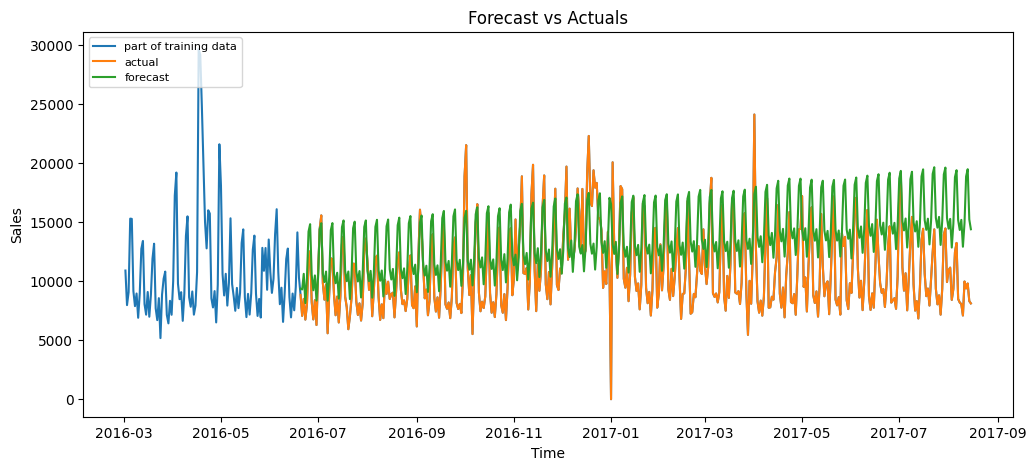

In [84]:

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(model_ARIMAp_pred, label='forecast')

plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### 5.5.3 Evaluating ARIMA with only promotional values as variables<a id='5.5.3'></a>

In [85]:
model_ARIMAp_name = 'ARIMA with promo exogenous only'
model_ARIMAp_mape = mape(X_te[2],model_ARIMAp_pred)
model_ARIMAp_r2 = r2(X_te[2],model_ARIMAp_pred)

In [86]:
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_ARIMAp_name,model_ARIMAp_mape,model_ARIMAp_r2))

For ARIMA with promo exogenous only model:
MAPE = 33.94
R^2 = 0.4344


As expected, removing all seasonality (aside from weekly) from the ARIMA model makes it unusable.

#### 5.6 Combining ARIMA with TBATS<a id='5.6'></a>

One final strategy that sometimes yields better results is to combine differing algorithms together to create a slightly more accurate model. We have seen that our second iteration of TBATS has been the lowest-scoreing MAPE thus far (13.81), while also the Fourier/promo ARIMA has had the highest R^2 (0.61969).

If we endeavour to find a happy midway point between the results of these two models, then we may see improvement.

We will check the best way to combine these results by using weighted averages. The two models will be weighted with weights equaling 1.00, and each step of one tenth of one percent will be tested. The weight combination resulting in the lowest MAPE (using highest R^2 as tie-breaker), can then be compared to the other models..

In [714]:
list_combos = []
for i in np.linspace(0,1,1001):
    
    combos = (model_ARIMAfp_pred * i) + (y_pred_TBATS2 * (1-i))
    
    model_combos_mape = mape(X_te[2],combos)
    model_combos_r2 = r2(X_te[2],combos)
    list_combos.append((i,(1-i),model_combos_mape,model_combos_r2))

In [715]:
list_combos_df = pd.DataFrame(list_combos, columns=['% ARIMA','% TBATS','MAPE','R^2'])
list_combos_df.sort_values(['MAPE','R^2'],ascending=[True,False])

,% ARIMA,% TBATS,MAPE,R^2
212,0.212,0.788,13.61,0.63149
211,0.211,0.789,13.61,0.63142
210,0.210,0.790,13.61,0.63134
209,0.209,0.791,13.61,0.63127
208,0.208,0.792,13.61,0.63120
...,...,...,...,...
996,0.996,0.004,16.73,0.64912
997,0.997,0.003,16.74,0.64910
998,0.998,0.002,16.75,0.64907
999,0.999,0.001,16.75,0.64905


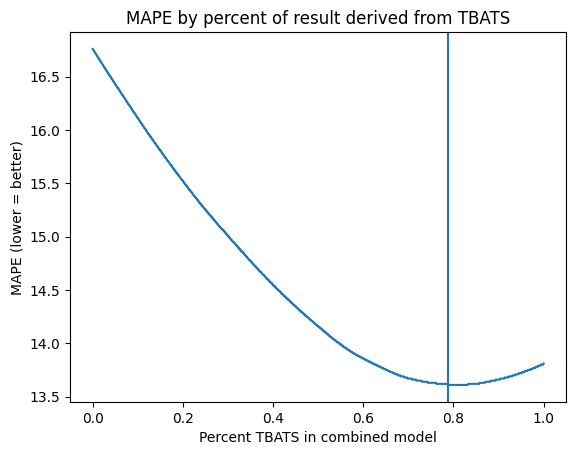

In [716]:
plt.plot(list_combos_df['% TBATS'],list_combos_df['MAPE'])
plt.title('MAPE by percent of result derived from TBATS')
plt.xlabel('Percent TBATS in combined model')
plt.axvline(0.788)
plt.ylabel('MAPE (lower = better)')

plt.plot();

##### 5.6.1 Plotting the best ARIMA and TBATS combination model<a id='5.6.1'></a>

In [717]:
combo = (model_ARIMAfp_pred * 0.212) + (y_pred_TBATS2 * 0.788)

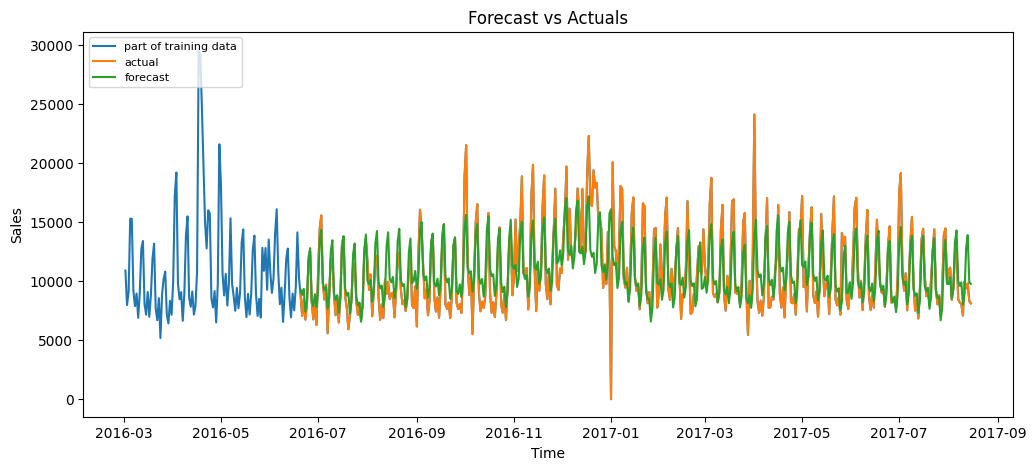

In [718]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data[data.index>'2016-03-01'], label='part of training data')
plt.plot(X_te[2], label='actual')
plt.plot(combo, label='forecast')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##### 5.6.2 Evaluating ARIMA and TBATS combination model<a id='5.6.2'></a>

In [719]:
model_combo_name = 'ARIMA/TBATS combo'
model_combo_mape = mape(X_te[2],combo)
model_combo_r2 = r2(X_te[2],combo)
print("For {} model:\nMAPE = {}\nR^2 = {}".format(model_combo_name,model_combo_mape,model_combo_r2))

For ARIMA/TBATS combo model:
MAPE = 13.61
R^2 = 0.63149


As we can clearly see, the combination model has lowered our MAPE to the lowest value seen, and raised our R^2 to the second-highest value seen.

### 6.0 Final model evaluation<a id='6.0'></a>

#### 6.1 Model comparison: MAPE<a id='6.1'></a>

In [720]:
model_names = [model_ARIMA_basic_name,model_SARIMA_name,model_TBATS_name,model_TBATS_name2,model_ARIMAfp_name,model_ARIMAf_name,model_ARIMAp_name,model_combo_name]
mapes = [model_ARIMA_basic_mape,model_SARIMA_mape,model_TBATS_mape,model_TBATS_mape2,model_ARIMAfp_mape,model_ARIMAf_mape,model_ARIMAp_mape,model_combo_mape]
r2s = [model_ARIMA_basic_r2,model_SARIMA_r2,model_TBATS_r2,model_TBATS_r22,model_ARIMAfp_r2,model_ARIMAf_r2,model_ARIMAp_r2,model_combo_r2]

np.array([model_names,mapes,r2s])

compare_models_all = pd.DataFrame(np.array([model_names,mapes,r2s]).T,columns=['model_names','MAPE','R^2'])

Most businesses like to use MAPE as a performance metric, due in large part to the inherent understandable nature of percentages. MAPE calculates the average percent difference between actual and predicted values.

In [721]:
compare_models_all.sort_values("MAPE")

,model_names,MAPE,R^2
7,ARIMA/TBATS combo,13.61,0.63149
3,TBATS2,13.81,0.61295
1,Seasonal_ARIMA,13.93,0.51081
2,TBATS,15.42,0.5561
4,ARIMA with exogenous variables,16.76,0.64902
5,ARIMA with fourier exogenous only,16.82,0.5666
0,Basic_ARIMA,24.96,0.00222
6,ARIMA with promo exogenous only,33.94,0.4344


#### 6.2 Model timing<a id='6.2'></a>

A very important element that must be considered in data science is the temporal feasibility of running certain models. If a model is very accurate, but it takes an inordinate amount of time to run, while there is a similar and faster (but slightly less accurate) model available for use, there is an important decision to be made.

While we achieved our best results with the TBATS/ARIMA combination, the TBATS algorithm causes modeling to take an enormous amount of time.

This problem that we are solving involves 1782 unique time series. TBATS alone took 2 minutes and 27 seconds to model, fit, and predict one series. The exogenous-inclusive seasonal ARIMA took only 8 seconds to do the same steps.

In [712]:
tbats_minutes = round((2+(27/60))*1782)
arima_minutes = round((8/60)*1782)
print('TBATS timing for 1782 series :\n  ',
      tbats_minutes,'minutes =',round(tbats_minutes/60,2),'hours =',round(tbats_minutes/60/24,2),'days\n')
print('ARIMA timing for 1782 series :\n  ',
      arima_minutes,'minutes =',round(arima_minutes/60,2),'hours =',round(arima_minutes/60/24,2),'days\n')

TBATS timing for 1782 series :
   4366 minutes = 72.77 hours = 3.03 days

ARIMA timing for 1782 series :
   238 minutes = 3.97 hours = 0.17 days



"Time is money" is a true statement. From a business perspective, the greater tradgedy would be relying upon a model that cannot update in a timely fashion. For this reason, we will likely need to move forward with the exogenous variable-inclusive seasonal ARIMA, with a run time of about **3 hours.** Compared to the TBATS timing of over **3 DAYS**, there is no competition.

An automated program could run the 1782 ARIMA models each morning before any employees enter the building. However, the TBATS models would be obsolete by days before they could even finish running. <u>A model without the most recent data is an inaccurate model, and that is not acceptable.</u>

From a practical standpoint, the proper decision is to use our chosen ARIMA for the modeling of our data.

#### 6.3 Model comparison: R^2<a id='6.3'></a>

According to recent research, while MAPE is more widely accepted, the coefficint of determination (R^2) is still the the best evaluation metric we could use.

"Our results demonstrate that the coefficient of determination (R-squared) is more informative and truthful than SMAPE, and does not have the interpretability limitations of MSE, RMSE, MAE and MAPE." [8]

[8] https://pubmed.ncbi.nlm.nih.gov/34307865/

In [722]:
compare_models_all.sort_values("R^2",ascending=False)

,model_names,MAPE,R^2
4,ARIMA with exogenous variables,16.76,0.64902
7,ARIMA/TBATS combo,13.61,0.63149
3,TBATS2,13.81,0.61295
5,ARIMA with fourier exogenous only,16.82,0.5666
2,TBATS,15.42,0.5561
1,Seasonal_ARIMA,13.93,0.51081
6,ARIMA with promo exogenous only,33.94,0.4344
0,Basic_ARIMA,24.96,0.00222


### 7.0 Summary<a id='7.0'></a>

In this pre-processing and training notebook, we took the data and singled out a single store/product combination that was of interest. This data subset was thn used in our baseline modeling. We determined the seasonality and periodicities in the data using statistical tests like the Augmented Dickey-Fuller, the KPSS, the OCSB, and the CH tests. Using this knowledge, we visualized the autocorrelation and partial autocorrelation, and determined the p,d,q and P,D,Q for making models using our first algorithm, ARIMA.

Using the Mean Average Percent Error (MAPE) and the coefficient of determination (R^2) as our performance metrics, we first split the data into training and testing splits. A basic ARIMA with no parameter tuning turned out poorly, as expected. However, as we tuned the parameters more, the results improved. The seasonal ARIMA done second turned out to have the third-lowest MAPE of the eight models.

Following those ARIMAs, we turned to an algorithm which can handle multiple periodicities called TBATS. The original TBATS run scored mediocrely; however, once the precise seasonal periods were used, TBATS quickly jumped to best-performing model, with the lowest MAPE and highests R^2 at the time.

Something that I wanted to try was including exogenous variables in a model. TBATS cannot handle exogenous variables, so we went back to ARIMA and intorduced the provided "promotional" items for sale. We also included Fourier transformations to imitate having multiseasonal peiodicity. These results were varied. Using both promotional information and Fourier produced the result that ended up with the highest R^2 score, and a respectable MAPE. The promotional-info-only ARIMA was terrible. The Fourier-only ARIMA out-performed the Fourier/promotional ARIMA in MAPE, but not R^2.

As a final part of the process, we wanted to see the effect of making an ensemble model with the results from our best-performing models for each metric. Combining TBATS and ARIMA with exogenous variables proved to be worth the investment. Winning in MAPE and placing second in R^2, the TBATS/ARIMA model uses calculated weights to give a final prediction.

The major issue with the TBATS/ARIMA model is the inordinate amount of time it takes to run all of our time series (over 3 days). The results would be obsolete by the time the analysis was finished. ***Therefore, in a business-conscious decision, the exogenous variable inclusive seasonal ARIMA will be the chosen model going forward, with a testing MAPE of 16.76, and an R^2 of 0.64902.***